In [12]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import xarray
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import os
import os.path as op
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

In [2]:
G17 = xarray.open_dataset('OR_ABI-L2-CMIPF-M6C07_G17_s20191030000339_e20191030009417_c20191030009458.nc')

In [4]:
g17_band7 = G17['CMI']

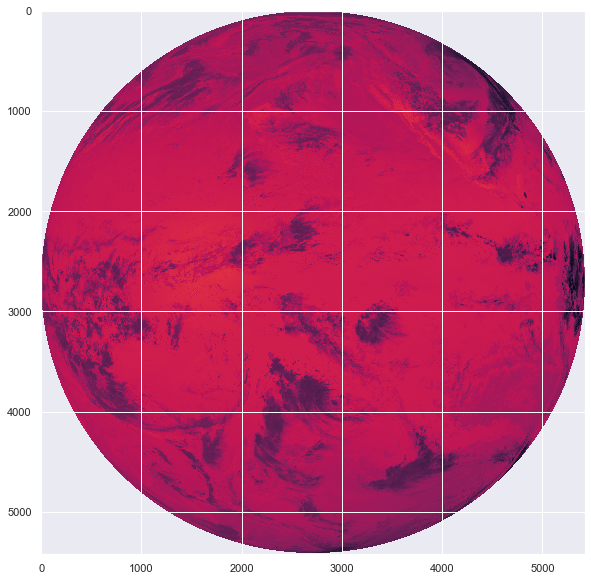

In [5]:
fig_1, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.imshow(g17_band7)

In [6]:
dat17 = G17.metpy.parse_cf('CMI')

In [7]:
geos17 = dat17.metpy.cartopy_crs

In [38]:
x17 = dat17.x
y17 = dat17.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes17 = (x17.min(), x17.max(), y17.min(), y17.max())
pyresample_extent_goes17 = [float(x17.min()), float(y17.min()), float(x17.max()), float(y17.max())]

Text(0.5, 1.0, 'GOES-17')

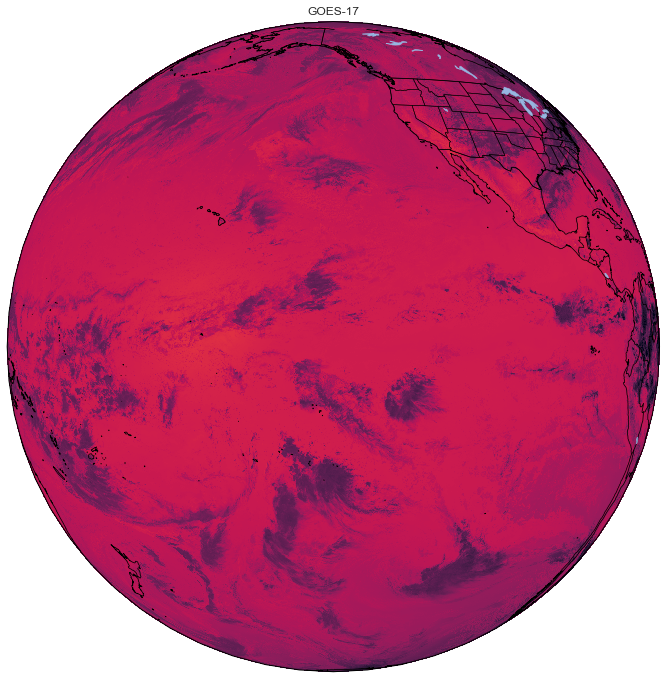

In [10]:
fig_2 = plt.figure(figsize=(12, 12))

ax1_2 = fig_2.add_subplot(1, 1, 1, projection=geos17)


## GOES 17
ax1_2.imshow(g17_band7, origin='upper', extent=cartopy_extent_goes17,
           transform=geos17)
ax1_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax1_2.set_title('GOES-17')



In [34]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

big_box_extent_pc_cartopy = [-116, -95, -10, 10]
big_box_extent_mc = mc.transform_points(pc, 
                    np.array(big_box_extent_pc_cartopy[:2]),
                    np.array(big_box_extent_pc_cartopy[2:])).ravel()
big_box_extent_mc_cartopy = [
    big_box_extent_mc[0],
    big_box_extent_mc[3],
    big_box_extent_mc[1],
    big_box_extent_mc[4]
]
roi_extent_pc_cartopy = [-109.59326, -102.40674, 
                          8.94659, -8.94656]
roi_extent_mc = mc.transform_points(pc, 
                    np.array(roi_extent_pc_cartopy[:2]),
                    np.array(roi_extent_pc_cartopy[2:])).ravel()
roi_extent_mc_cartopy = [
    roi_extent_mc[0],
    roi_extent_mc[3],
    roi_extent_mc[1],
    roi_extent_mc[4]
]
roi_extent_mc_pyresample = [
    roi_extent_mc[0],
    roi_extent_mc[1],
    roi_extent_mc[3],
    roi_extent_mc[4]
]
print(big_box_extent_mc_cartopy)
print(roi_extent_mc_cartopy)

[-12913060.932019735, -10575351.62536099, -1111475.102852224, 1111475.1028522253]
[-12199865.897574836, -11399866.150599161, 993361.388724224, -993358.0300969948]


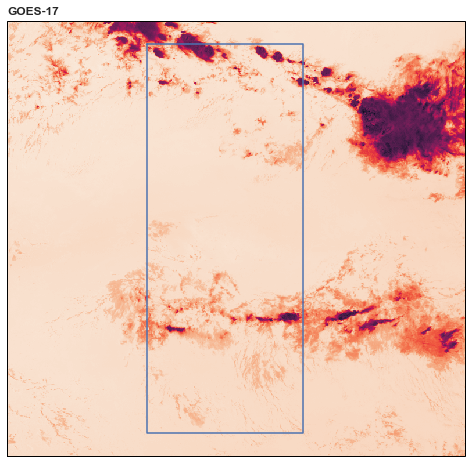

In [32]:
fig_3 = plt.figure(figsize=(15, 8))

ax_3 = fig_3.add_subplot(1, 1, 1, projection=mc)

ax_3.set_extent(big_box_extent_mc_cartopy, crs=mc)

roi_x = [roi_extent_mc_cartopy[0], 
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[0],
         roi_extent_mc_cartopy[0]]

roi_y = [roi_extent_mc_cartopy[2], 
         roi_extent_mc_cartopy[2],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[2]]
# GOES17
ax_3.imshow(g17_band7, origin='upper',
           extent=cartopy_extent_goes17,
           transform=geos17,
           interpolation='none')
ax_3.add_feature(ccrs.cartopy.feature.STATES)
ax_3.coastlines(resolution='50m', color='black', linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_3.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_3.set_title('GOES-17', loc='left', fontweight='bold')
ax_3.plot(roi_x, roi_y,'b-')


In [43]:
g17_band7_ma = np.ma.masked_array(g17_band7)

In [44]:
goes17_params = geos17.proj4_params
goes17_area = geometry.AreaDefinition('GOES-17', 'CONUS',
                                'GOES-17', goes17_params,
                             g17_band7.shape[1], g17_band7.shape[0],
                              pyresample_extent_goes17)
area_mc_def = geometry.AreaDefinition('areaTest', 'Equator-ROW', 'areaTest',
                                  mc.proj4_params,
                                    500, 200,
                                   roi_extent_mc_pyresample)
geos17_con_nn = image.ImageContainerNearest(g17_band7_ma, 
                                            goes17_area, 
                                            radius_of_influence=50000)

# Here we are using pyresample for the remapping
area_mc_con_nn = geos17_con_nn.resample(area_mc_def)
image_mc_17 = area_mc_con_nn.image_data




Text(0.0, 1.0, 'GOES-17')

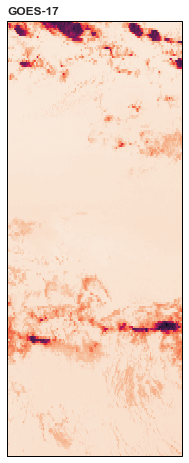

In [49]:
fig_4 = plt.figure(figsize=(15, 8))

ax_4 = fig_4.add_subplot(1, 1, 1, projection=mc)

ax_4.set_extent(roi_extent_mc_cartopy, crs=mc)


# GOES17
ax_4.imshow(image_mc_17, origin='upper',
           extent=roi_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_4.set_title('GOES-17', loc='left', fontweight='bold')


In [51]:
print('mean: ',image_mc_17.mean())
print('std: ',image_mc_17.std())

mean:  295.43573
std:  7.81938


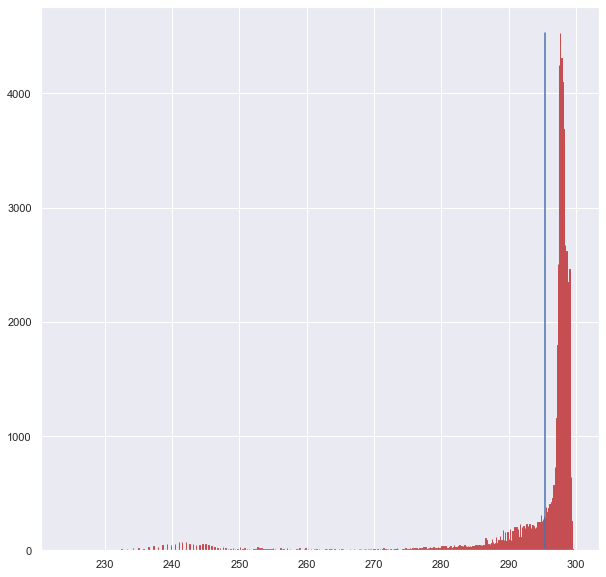

In [82]:
fig_5, ax_5 = plt.subplots(figsize=(10, 10))
values = np.array(image_mc_17).ravel()
counts, bins, _ = ax_5.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')
_=ax_5.plot([values.mean(),values.mean()],[0,counts.max()],c='b')

In [80]:
counts, bins, _ = ax_5.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')

In [81]:
counts

array([ 2.,  0.,  0., ...,  8., 10.,  3.])